In [4]:
! pip install spacy
! pip install wordcloud

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 368kB 22.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from pprint import pprint
import nltk
from nltk.corpus import words, brown, gutenberg
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
DATA_FILE = "hamlet.txt"

In [30]:
RE_SCENE_HEADER = r"^\tHAMLET\n+ACT [A-Z]+\n+SCENE [A-Z]+\t.+\n+"
RE_SPEECH_HEADER = r"(?<=\n\n)[A-Z][A-Za-z ]+\t"
RE_EMPTY_LINE = r"^[\s|]*$"
RE_CHAR_NAME = r"(^[A-Z][A-Za-z ]+)(?:\t)"
RE_ACTIONS = r"\[([^\]]*\n)*[^\]]*\]"

In [31]:
def re_search_all(regex_pat: str, text: str) -> list:
    """Returns a list of all match objects"""
    return list( re.finditer(regex_pat, text, flags=re.MULTILINE) )

def re_split(regex_pat: str, text: str) -> list:
    """Custom regex split solution, re.split() either throw away the delimiter 
    or keep it as separate items, doesn't suit the needs here.
    """
    matches = re_search_all(regex_pat, text)
    split_positions = [m.start() for m in matches]
    
    if split_positions[0] > 0:  # add starting position if it's not there
        split_positions = [0] + split_positions
    split_positions = split_positions + [len(text)]  # add end position
    split_positions

    splits = []
    n_splits = len(split_positions) - 1
    for i in range(n_splits):
        splits.append(text[split_positions[i] : split_positions[i+1]])
    
    assert(''.join(splits) == text)
    
    return splits

def get_scene_header(scene: str) -> str:
    return re.search(RE_SCENE_HEADER, scene, flags=re.MULTILINE).group(0)

def strip_scene_header(scene: str) -> str:
    return re.sub(RE_SCENE_HEADER, "", scene, flags=re.MULTILINE)

def get_scene_dialogs(scene: str) -> str:
    scene_body = strip_scene_header(scene)
    dialogs = re_split(RE_DIALOG_HEADER, scene_body)
    return dialogs

def get_dialog_lines(dialog: str) -> list: 
    dialog = re.sub(RE_ACTIONS, "", dialog, flags=re.MULTILINE)
    dialog = re.sub(RE_CHAR_NAME, "", dialog, flags=re.MULTILINE)
    lines = [line for line in re.split(r"\n", dialog)
             if not re.match(RE_EMPTY_LINE, line)]
    return lines

def get_character_lines(scenes: list) -> dict:
    char_lines_dict = {}
    for scene in scenes:
        dialogs = get_scene_dialogs(scene)
        for d in dialogs:
            chars = re.findall(RE_CHAR_NAME, d, flags=re.MULTILINE)
            lines = get_dialog_lines(d)
            for c in chars:
                if c in char_lines_dict:
                    char_lines_dict[c] = char_lines_dict[c] + lines
                else: 
                    char_lines_dict[c] = lines
    return char_lines_dict

def count_character_lines(char_lines_dict: dict) -> pd.Series:
    char_n_lines = {}
    for char in char_lines_dict:
        char_n_lines[char] = len(char_lines_dict[char])
    return pd.Series(char_n_lines)

def get_all_scripts(scenes: list):
    all_scenes_text = ''
    for scene in scenes:
        dialogs = get_scene_dialogs(scene)
        all_scenes_text = all_scenes_text + '\n'.join(dialogs)
    return all_scenes_text

def spacy_lemmatise(text: str) -> list:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha]
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    context = []
    for i in range(len(tokens)):
        i_start = i-5 if i>=5 else 0
        i_end = i+5 if i<=len(tokens)-5 else len(tokens)
        context.append(' '.join([t for t in tokens[i_start:i_end]]))
    lemma_map = pd.DataFrame({'token': tokens, 'lemma': lemmas, 'context': context}).drop_duplicates()
    return tokens, lemmas, lemma_map

def get_common_english_words(topn: int) -> list:
    return pd.Series([w.lower() for w in brown.words()])\
            [lambda s: s.str.isalpha()]\
            .value_counts().head(topn).index.values.tolist()

def show_word_cloud(text: str):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    fig, ax = plt.subplots(figsize=(15,8))
    _ = plt.imshow(wordcloud, interpolation='bilinear')
    _ = plt.axis("off")

In [32]:
full_book = open(DATA_FILE).read()

In [103]:
def re_search(pat: str, text: str) -> str:
    """re.search() wrapper
    returns first matching group, with MULTILINE flag
    returns N/A if not found"""
    match = re.search(pat, text, flags=re.MULTILINE)
    if match:
        return match.group(1)
    else:
        return "N/A"

def get_act_name(scene_header: str) -> str:
    return re_search(r"^\tHAMLET\n+(ACT [A-Z]+)(\n+)", scene_header)
    
def get_scene_name(scene_header: str) -> str:
    return re_search(r"(^SCENE [A-Z]+)(?:\t)", scene_header)
    
def get_scene_title(scene_header: str) -> str:
    return re_search(r"(?:^SCENE [A-Z]+\t)(.+$)", scene_header)
    
def split_scenes(full_text: str) -> pd.DataFrame:
    scenes = re_split(r"^\tHAMLET\n+ACT [A-Z]+\n+SCENE [A-Z]+\t.+\n+", full_text)
    
    scenes_dict_list = []
    for s in scenes:
        act_name = get_act_name(s)
        scene_name = get_scene_name(s)
        scene_title = get_scene_title(s)
        scene_text = s
        scenes_dict_list.append({'act_name': act_name, 'scene_name': scene_name, 
                                'scene_title': scene_title, 'scene_text': scene_text})
    
    scenes_df = pd.DataFrame(scenes_dict_list)
    assert(''.join(scenes_df.scene_text) == full_text)
    return scenes_df

def split_scene_into_lines(scene_df_row: pd.Series) -> pd.DataFrame:
    scene_header = 

In [104]:
scenes_df = split_scenes(full_book)

In [105]:
scenes_df

,act_name,scene_name,scene_text,scene_title
0,N/A,N/A,\tHAMLET\n\n\n\tDRAMATIS PERSONAE\n\n\nCLAUDIU...,N/A
1,ACT I,SCENE I,\tHAMLET\n\n\nACT I\n\n\n\nSCENE I\tElsinore. ...,Elsinore. A platform before the castle.
2,ACT I,SCENE II,\tHAMLET\n\n\nACT I\n\n\n\nSCENE II\tA room of...,A room of state in the castle.
3,ACT I,SCENE III,\tHAMLET\n\n\nACT I\n\n\n\nSCENE III\tA room i...,A room in Polonius' house.
4,ACT I,SCENE IV,\tHAMLET\n\n\nACT I\n\n\n\nSCENE IV\tThe platf...,The platform.
5,ACT I,SCENE V,\tHAMLET\n\n\nACT I\n\n\n\nSCENE V\tAnother pa...,Another part of the platform.
6,ACT II,SCENE I,\tHAMLET\n\n\nACT II\n\n\n\nSCENE I\tA room in...,A room in POLONIUS' house.
7,ACT II,SCENE II,\tHAMLET\n\n\nACT II\n\n\n\nSCENE II\tA room i...,A room in the castle.
8,ACT III,SCENE I,\tHAMLET\n\n\nACT III\n\n\n\nSCENE I\tA room i...,A room in the castle.
9,ACT III,SCENE II,\tHAMLET\n\n\nACT III\n\n\n\nSCENE II\tA hall ...,A hall in the castle.


In [7]:
char_lines = get_character_lines(scenes)

char_lines['First Sailor']

['God bless you, sir.',
 "He shall, sir, an't please him. There's a letter for",
 '\tyou, sir; it comes from the ambassador that was',
 '\tbound for England; if your name be Horatio, as I am',
 '\tlet to know it is.']

In [8]:
# this version seems to be missing some lines?

char_num_of_lines = count_character_lines(char_lines)

char_num_of_lines.sort_values(ascending=False)

HAMLET               1148
KING CLAUDIUS         513
LORD POLONIUS         354
HORATIO               231
OPHELIA               168
LAERTES               153
QUEEN GERTRUDE        138
ROSENCRANTZ            96
Ghost                  95
MARCELLUS              67
GUILDENSTERN           52
First Player           52
First Clown            51
Player King            44
BERNARDO               38
Player Queen           30
Gentleman              24
VOLTIMAND              22
Second Clown           18
REYNALDO               15
Captain                12
FRANCISCO              10
PRINCE FORTINBRAS       8
LUCIANUS                6
First Sailor            5
Messenger               5
Prologue                3
Danes                   3
All                     2
CORNELIUS               1
Servant                 1
dtype: int64

In [9]:
all_scripts = get_all_scripts(scenes)  # all lines and actions excluding headers

print(all_scripts[:300])

	[FRANCISCO at his post. Enter to him BERNARDO]


BERNARDO	Who's there?


FRANCISCO	Nay, answer me: stand, and unfold yourself.


BERNARDO	Long live the king!


FRANCISCO	Bernardo?


BERNARDO	He.


FRANCISCO	You come most carefully upon your hour.


BERNARDO	'Tis now struck twelve; get thee to bed, 


In [10]:
# tried lemmatising, turned out it wasn't necessary with a bigger dictionary
tokens, tokens_lemmatised, lemma_map = spacy_lemmatise(all_scripts)

In [11]:
# brown corpus was created in 1961, seems to be a good choice for older literature
common_english_words = get_common_english_words(10000)

common_english_words[:10]

['the', 'of', 'and', 'to', 'a', 'in', 'that', 'is', 'was', 'he']

In [12]:
# Sometimes characters are referred to without their title
char_names = list(char_lines.keys()) + ['CLAUDIUS', 'POLONIUS', 'GERTRUDE', 'FORTINBRAS']
char_names = [c.lower() for c in char_names]

# Convert to Series since list comprehension was too slow
# -pron- token is added by spacy
tokens_unusual = pd.Series(tokens)\
                [lambda s: ~s.isin(common_english_words + ['-pron-'] + char_names)]  

tokens_unusual.value_counts()

tis            63
hath           54
exeunt         34
ay             33
clown          28
doth           25
nay            21
denmark        18
madness        18
sword          16
hast           14
norway         12
majesty        12
re             11
oft            11
ho             11
villain        11
offence        10
ere            10
madam          10
foul           10
ha              9
twere           9
pyrrhus         9
wherein         8
thine           8
dost            8
honour          7
hither          7
awhile          7
               ..
stowed          1
nettles         1
distempered     1
negligence      1
hyrcanian       1
overthrown      1
pronounce       1
comrade         1
copied          1
wildness        1
levied          1
individable     1
winking         1
spheres         1
chariest        1
chopine         1
cicatrice       1
beteem          1
bait            1
clothe          1
loins           1
vial            1
lethe           1
chiefest        1
pester    

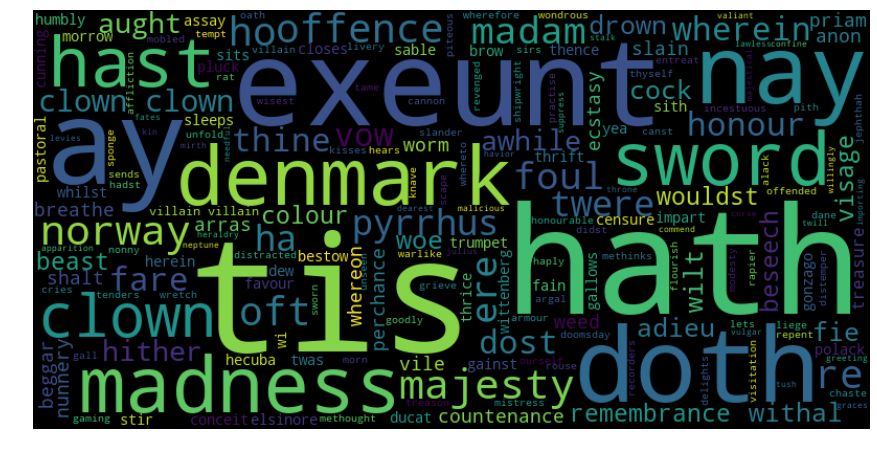

In [13]:
show_word_cloud(' '.join(tokens_unusual))